<a href="https://colab.research.google.com/github/dhruv-pandit/PRA3024/blob/main/Cosmology_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
 #Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt


In [155]:
pip install latex

  Created wheel for latex: filename=latex-0.7.0-cp37-none-any.whl size=7607 sha256=ed7889fb099d13cf0c0f65f46fd38d35bae0356e64654bb3c0960c6fa146fd53
  Stored in directory: /root/.cache/pip/wheels/a5/00/74/5aed853dec3fbc45e9c9cf4949f664f1bd8b6f3e6def432019
  Created wheel for tempdir: filename=tempdir-0.7.1-cp37-none-any.whl size=2213 sha256=f6ffed818add2cc239e54bb20e9beb13ed6b5604d71d661268e205caf507af4c
  Stored in directory: /root/.cache/pip/wheels/7b/f2/40/6806964a69dfe3e46eff51b06a9a036af80b933479536fa295
  Created wheel for data: filename=data-0.4-cp37-none-any.whl size=7248 sha256=27d3a013ac9525b269b83fb3cf78b90e00ebc834921cfa036688e4bbb3984dc1
  Stored in directory: /root/.cache/pip/wheels/f6/09/e5/5afbc45fb0de471541092c7cd8b48d3483be68b1890955e6b9
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-cp37-none-any.whl size=2783 sha256=1c5d1e4f34c276aebfa7c4ad6ca3d5a24aff6b3087821d2f1671f98b3b4af0d2
  Stored in directory: /root/.cache/pip/wheels/05/ef/eb/27a815601fa45bbb030

In [164]:
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.1.3, Matplotlib version: 3.2.2


In [168]:
PARSEC = 30856776000000.0  # in kilometres
c = 299792.46 #speed of light in km/s


# Hubble rate
def Hubble(z, h, omega_m, omega_l):
    return  h * np.sqrt(omega_l + omega_m*pow(1.+z,3) + (1. - omega_m - omega_l) * pow(1+z,2)) #https://en.wikipedia.org/wiki/Hubble%27s_law equation obtained from here

    

In [103]:
import scipy.integrate as integrate
#FUNCTIONS

def function(z, h, omega_m, omega_l): #equation to be integrated
  return 1/ ( h * np.sqrt(omega_l + omega_m*pow(1.+z,3) + (1. - omega_m - omega_l) * pow(1+z,2)))

def integral(z, h, omega_m, omega_l): 
  return integrate.quad(function, 0, z, args = (h, omega_m, omega_l))[0]

def dZ(z, h, omega_m, omega_l):
  return h * integral(z, h, omega_m, omega_l)

#----------------------------------------------------------------------------------------------------

#LUMINOSITY DISTANCE

def dL(z, h, omega_m, omega_l):
  equation_start = (c / h) * (1 + z)
  Z = dZ(z, h, omega_m, omega_l)
  omega_k = 1 - omega_m - omega_l

  if omega_k > 0 :
    equation_end = (1 / np.sqrt(omega_k)) * np.sinh(np.sqrt(omega_k) * Z)

  elif omega_k ==0:
    equation_end = Z

  elif omega_k < 0:
    omega_k = -omega_k
    equation_end = (1 / np.sqrt(omega_k)) * np.sin(np.sqrt(omega_k) * Z)

  return equation_start * equation_end


#-----------------------------------------------------------------------------
#DISTANCE MODULUS  

def mu(z, h, omega_m, omega_l):
  return 5 * np.log10(dL(z, h, omega_m, omega_l) * (1E5)) # d is already in pc so we need to convert it to megaparsecs to match our data, and then divide by 10



 

#----------------------------------------------------------------------------
#CHI CALCULATOR


def chi_calculator(h, omega_m ,omega_l, zs, distance_modulus, error):
  chi = 0
  for num in range(len(zs)):
    mu_theoretical = mu(zs[num], h, omega_m, omega_l)
    chi += ((mu_theoretical - distance_modulus[num]) ** 2 )/ (error[num] **2)  

  return chi





In [99]:

dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus




[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [169]:
epochs = 1000 #This takes about 50 seconds to run. I have included a stopwatch to count it. This number can also be changed. 
#i initially started with 200 epochs, and gradually increased it to 1000 since i wasnt getting enough data points

h_proposed = np.random.normal(loc = 70, scale  = 1.5 , size= epochs)
omega_m_proposed = np.random.normal(loc = 0.3, scale  = 0.1, size= epochs)
omega_l_proposed = np.random.normal(loc = 0.7, scale  = 0.1, size= epochs)



In [172]:
import time
startTime = time.time()

old_parameters = [70, 0.3, 0.7]
chi_old = chi_calculator(old_parameters[0], old_parameters[1], old_parameters[2], zs, dist_mod, err_dist_mod)

parameters = []
accepted_parameters = []
for epoch in range(epochs):
  proposed_parameter = [h_proposed[epoch], omega_m_proposed[epoch], omega_l_proposed[epoch]]

  chi_prop = chi_calculator(proposed_parameter[0], proposed_parameter[1], proposed_parameter[2], zs, dist_mod, err_dist_mod)

  likelihood = np.exp(((chi_old) - (chi_prop)) / 2) 
  prior = (np.random.uniform(0,1) / np.random.uniform(0,1)) #here i use a uniform distribution as a non informative prior distribution 

  r = np.random.uniform(0,1)
  
  
  if r < (likelihood * prior):
    old_parameters = proposed_parameter
    chi_old = chi_prop
    accepted_parameters.append(old_parameters)
  parameters.append(old_parameters)
print(len(accepted_parameters))
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print("H0                                          Omega M                                           Omega L")
for array in parameters:
  print(str(array[0])+"                        " + str(array[1])+"                                " + str(array[2]))


70
Execution time in seconds: 50.84094047546387
H0                                          Omega M                                           Omega L
70                        0.3                                0.7
69.49201564922657                        0.36601554231651734                                0.7399523087967561
69.49201564922657                        0.36601554231651734                                0.7399523087967561
69.49201564922657                        0.36601554231651734                                0.7399523087967561
69.96573838380755                        0.3203776808631634                                0.7336047514329241
69.96573838380755                        0.3203776808631634                                0.7336047514329241
69.96573838380755                        0.3203776808631634                                0.7336047514329241
69.96573838380755                        0.3203776808631634                                0.7336047514329241
69.965738383

Removed no burn in
(1000, 3)


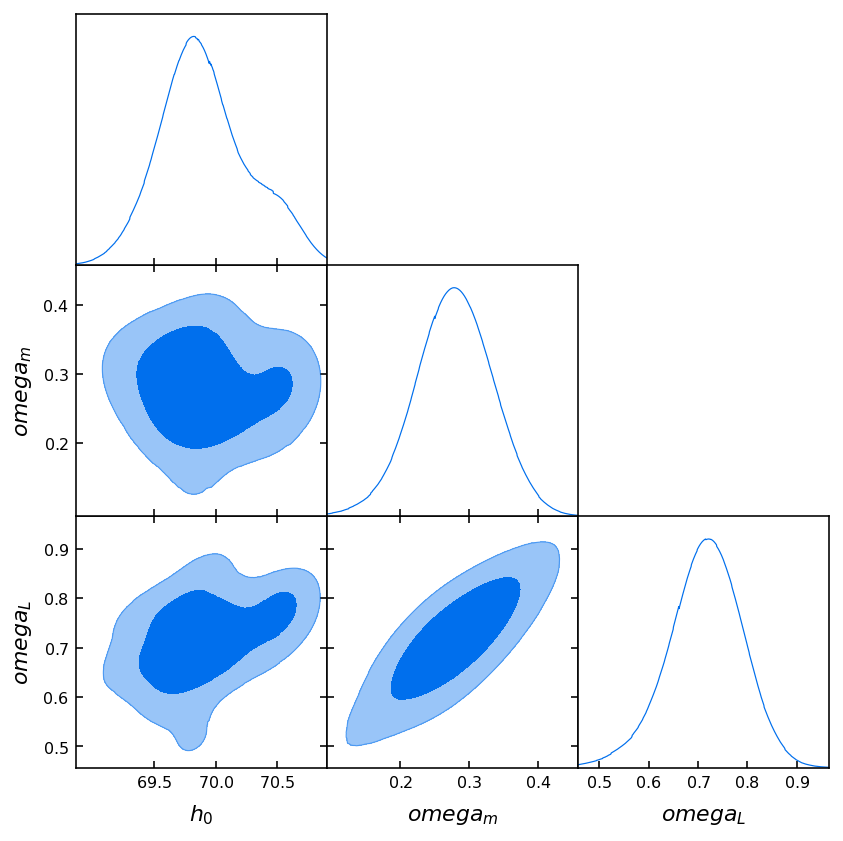

In [173]:
from matplotlib import rc
rc('text', usetex = False)
parH = []
parOM = []
parOL = []
for array in parameters:
  parH.append(array[0])
  parOM.append(array[1])
  parOL.append(array[2])

parH = np.asarray(parH)
parOM = np.asarray(parOM)
parOL = np.asarray(parOL)
my_dim = 3
my_samples = np.array([parH, parOM, parOL])
names = ['H0', 'OmegaM', 'OmegaL']
labels = ['h_0', 'omega_m', 'omega_L']
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim))))

samples = MCSamples(samples=my_samples,names = names, labels = labels)

print(np.shape(my_samples))
g = plots.get_subplot_plotter()
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
g.triangle_plot(samples, filled=True)

In [186]:
min = 1000
max = 0
minArray=[]
maxArray=[]
for array in parameters:
  if array[0] > max:
    max = array[0]
    maxArray = array
  if array[0] < min:
    min = array[0]
    minArray = array
print(minArray)  
print(maxArray)  

[69.07605133914922, 0.34155376983791824, 0.7463935503454838]
[70.68950378378916, 0.26280928198561976, 0.7383008169940326]


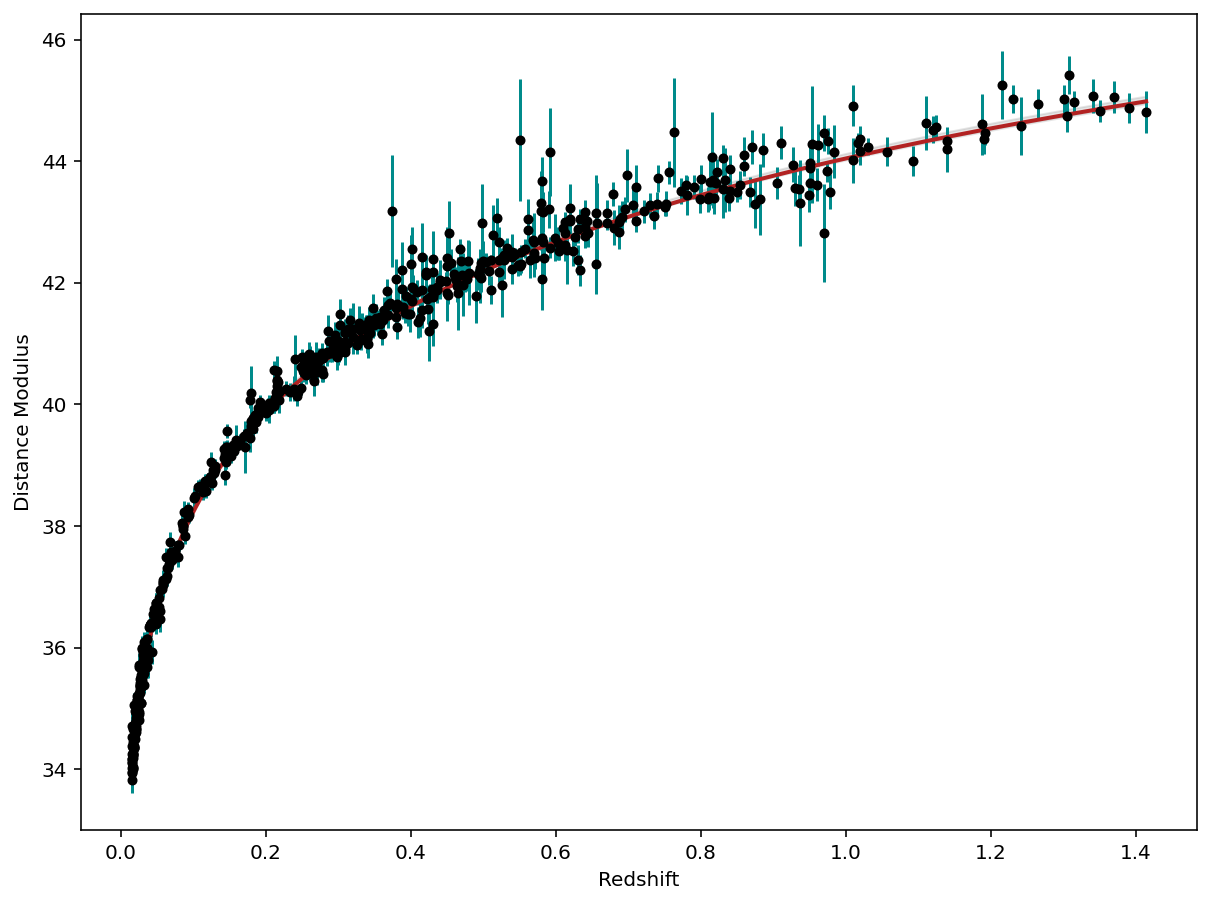

In [189]:
SPEED_OF_LIGHT = 299792.458 # in km/s

def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 
zsort = sorted(zs)
d_best_fit, d_min, d_max = [], [], []

for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, 69.70719209480269, 0.3008997625932943, 0.7927008934610209))
    d_min.append(theor_distance_modulus(z, maxArray[0], maxArray[1], maxArray[2]))
    d_max.append(theor_distance_modulus(z, minArray[0], minArray[1], minArray[2]))
    
plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2.)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()